<a href="https://colab.research.google.com/github/nantmoe-theingi/airbnb-nz-deception-sentiment/blob/main/notebooks/02_distilBERT_deception.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np, pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
from datasets import Dataset
from transformers import (
    AutoTokenizer, AutoModelForSequenceClassification,
    TrainingArguments, Trainer, set_seed
)

set_seed(42)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

Device: cuda


In [ ]:
# Load and Split Dataset
df = pd.read_csv("data/deception_opinion_cleaned.csv")
df = df.dropna(subset=["text", "label"])
df["label"] = df["label"].astype(int)

train_df, temp_df = train_test_split(df, test_size=0.2, stratify=df["label"], random_state=42)
val_df, test_df = train_test_split(temp_df, test_size=0.5, stratify=temp_df["label"], random_state=42)

print(f"Train: {len(train_df)} | Val: {len(val_df)} | Test: {len(test_df)}")

Train: 1276 | Val: 160 | Test: 160


In [ ]:
# ===== DistilBERT sweep (simple & reliable) =====
import itertools, numpy as np, pandas as pd, torch, joblib
from pathlib import Path
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from transformers import (
    AutoTokenizer, AutoModelForSequenceClassification,
    Trainer, TrainingArguments, set_seed
)

# -------------------
# 0) Config & seeding
# -------------------
MODEL_NAME = "distilbert-base-uncased"
ROOT_DIR = Path("artifacts/distilbert_deception_sweep")
ROOT_DIR.mkdir(parents=True, exist_ok=True)
set_seed(42)
torch.backends.cudnn.benchmark = False

# -------------------
# 1) Tokenizer & metric
# -------------------
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

def tokenize(batch):
    return tokenizer(batch["text"], padding="max_length", truncation=True, max_length=256)

train_ds = Dataset.from_pandas(train_df).map(tokenize, batched=True)
val_ds   = Dataset.from_pandas(val_df).map(tokenize, batched=True)
test_ds  = Dataset.from_pandas(test_df).map(tokenize, batched=True)

train_ds.set_format("torch", columns=["input_ids", "attention_mask", "label"])
val_ds.set_format("torch", columns=["input_ids", "attention_mask", "label"])
test_ds.set_format("torch", columns=["input_ids", "attention_mask", "label"])

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=1)
    return {
        "accuracy":  accuracy_score(labels, preds),
        "precision": precision_score(labels, preds, pos_label=1),
        "recall":    recall_score(labels, preds, pos_label=1),
        "f1":        f1_score(labels, preds, pos_label=1),
    }

def new_model():
    return AutoModelForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=2)

Map:   0%|          | 0/1276 [00:00<?, ? examples/s]

Map:   0%|          | 0/160 [00:00<?, ? examples/s]

Map:   0%|          | 0/160 [00:00<?, ? examples/s]

In [ ]:
# -------------------
# 2) Sweep space (kept small but meaningful)
# -------------------
grid = {
    "num_train_epochs": [2, 3, 4],
    "learning_rate": [1e-5, 2e-5, 3e-5],
    "lr_scheduler_type": ["linear", "cosine"],
    "warmup_ratio": [0.0, 0.06],
}

results = []

In [ ]:
# Reset deterministic mode in the current kernel (no restart needed)
import os, torch

# turn off strict determinism
torch.use_deterministic_algorithms(False)

# use safe, reproducible-enough defaults
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = False

# allow TF32 again (optional; keeps things simple)
torch.backends.cuda.matmul.allow_tf32 = True
torch.backends.cudnn.allow_tf32 = True

# remove cuBLAS workspace setting so cuBLAS won't complain
os.environ.pop("CUBLAS_WORKSPACE_CONFIG", None)

print("Deterministic mode OFF and can train now.")

Deterministic mode OFF and can train now.


In [ ]:

# -------------------
# 3) Run sweep
# -------------------
for epochs, lr, sched, warm in itertools.product(
    grid["num_train_epochs"], grid["learning_rate"],
    grid["lr_scheduler_type"], grid["warmup_ratio"]
):
    run_name = f"e{epochs}_lr{lr}_sch-{sched}_warm{warm}"
    output_dir = ROOT_DIR / "runs" / run_name
    output_dir.mkdir(parents=True, exist_ok=True)

    model = new_model()

    args = TrainingArguments(
        output_dir=str(output_dir),
        per_device_train_batch_size=8,
        per_device_eval_batch_size=8,
        learning_rate=lr,
        num_train_epochs=epochs,
        weight_decay=0.01,
        eval_strategy="epoch",
        save_strategy="epoch",
        load_best_model_at_end=True,
        metric_for_best_model="f1",
        greater_is_better=True,
        lr_scheduler_type=sched,
        warmup_ratio=warm,
        logging_steps=100,
        save_total_limit=1,   # keep it tidy
        report_to=[],         # no wandb/etc
        seed=42,
        fp16=False,           # keep simple; avoids cuBLAS determinism issues
    )

    trainer = Trainer(
        model=model,
        args=args,
        train_dataset=train_ds,
        eval_dataset=val_ds,
        tokenizer=tokenizer,
        compute_metrics=compute_metrics,
    )

    trainer.train()
    val_metrics = trainer.evaluate()
    results.append({
        "run": run_name, "epochs": epochs, "lr": lr,
        "scheduler": sched, "warmup": warm,
        **{k: round(val_metrics[k], 4) for k in
           ("eval_accuracy", "eval_precision", "eval_recall", "eval_f1")}
    })

    # free memory between runs
    del trainer, model
    if torch.cuda.is_available():
        torch.cuda.empty_cache()

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-2724274408.py:35: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.597700,0.418103,0.812500,0.784091,0.862500,0.821429
2,0.322600,0.425615,0.806250,0.747475,0.925000,0.826816


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-2724274408.py:35: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.601000,0.384153,0.850000,0.833333,0.875000,0.853659
2,0.293700,0.387483,0.825000,0.776596,0.912500,0.839080


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-2724274408.py:35: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.577800,0.364934,0.862500,0.837209,0.900000,0.867470
2,0.288800,0.344524,0.850000,0.818182,0.900000,0.857143


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-2724274408.py:35: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.593800,0.372173,0.868750,0.839080,0.912500,0.874251
2,0.288600,0.352538,0.837500,0.793478,0.912500,0.848837


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-2724274408.py:35: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.512200,0.308356,0.875000,0.865854,0.887500,0.876543
2,0.214700,0.372225,0.856250,0.813187,0.925000,0.865497


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-2724274408.py:35: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.527200,0.316954,0.875000,0.848837,0.912500,0.879518
2,0.211500,0.345218,0.875000,0.833333,0.937500,0.882353


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-2724274408.py:35: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.507000,0.300990,0.887500,0.878049,0.900000,0.888889
2,0.216400,0.310399,0.881250,0.867470,0.900000,0.883436


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-2724274408.py:35: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.530600,0.303204,0.875000,0.848837,0.912500,0.879518
2,0.222800,0.293660,0.887500,0.869048,0.912500,0.890244


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-2724274408.py:35: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.498900,0.281661,0.868750,0.893333,0.837500,0.864516
2,0.199000,0.407715,0.856250,0.820225,0.912500,0.863905


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-2724274408.py:35: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.522600,0.291415,0.881250,0.917808,0.837500,0.875817
2,0.200500,0.382019,0.875000,0.833333,0.937500,0.882353


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-2724274408.py:35: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.498500,0.267349,0.881250,0.896104,0.862500,0.878981
2,0.193600,0.357846,0.868750,0.839080,0.912500,0.874251


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-2724274408.py:35: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.529600,0.290389,0.900000,0.944444,0.850000,0.894737
2,0.216300,0.348427,0.875000,0.848837,0.912500,0.879518


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-2724274408.py:35: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.581700,0.364008,0.862500,0.829545,0.912500,0.869048
2,0.265800,0.387502,0.837500,0.775510,0.950000,0.853933
3,0.236200,0.345383,0.868750,0.831461,0.925000,0.875740


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-2724274408.py:35: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.632000,0.378901,0.831250,0.835443,0.825000,0.830189
2,0.277000,0.441102,0.831250,0.762376,0.962500,0.850829
3,0.240800,0.364501,0.868750,0.817204,0.950000,0.878613


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-2724274408.py:35: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.605700,0.349682,0.862500,0.845238,0.887500,0.865854
2,0.266400,0.405537,0.843750,0.777778,0.962500,0.860335
3,0.230700,0.371848,0.850000,0.804348,0.925000,0.860465


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-2724274408.py:35: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.627700,0.369249,0.843750,0.831325,0.862500,0.846626
2,0.268900,0.432696,0.831250,0.762376,0.962500,0.850829
3,0.235000,0.373362,0.862500,0.808511,0.950000,0.873563


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-2724274408.py:35: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.515600,0.304049,0.875000,0.875000,0.875000,0.875000
2,0.231800,0.409014,0.868750,0.810526,0.962500,0.880000
3,0.160600,0.383020,0.875000,0.833333,0.937500,0.882353


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-2724274408.py:35: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.554300,0.323392,0.862500,0.862500,0.862500,0.862500
2,0.255200,0.468113,0.837500,0.770000,0.962500,0.855556
3,0.176200,0.396487,0.875000,0.826087,0.950000,0.883721


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-2724274408.py:35: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.510700,0.307709,0.850000,0.868421,0.825000,0.846154
2,0.225100,0.376432,0.862500,0.815217,0.937500,0.872093
3,0.144300,0.387448,0.868750,0.824176,0.937500,0.877193


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-2724274408.py:35: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.552900,0.321951,0.868750,0.855422,0.887500,0.871166
2,0.252900,0.398403,0.862500,0.802083,0.962500,0.875000
3,0.169500,0.377373,0.868750,0.817204,0.950000,0.878613


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-2724274408.py:35: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.490500,0.335459,0.850000,0.937500,0.750000,0.833333
2,0.229400,0.416388,0.887500,0.852273,0.937500,0.892857
3,0.124100,0.428530,0.893750,0.870588,0.925000,0.896970


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-2724274408.py:35: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.541800,0.346500,0.850000,0.888889,0.800000,0.842105
2,0.224100,0.412182,0.850000,0.797872,0.937500,0.862069
3,0.123900,0.431161,0.887500,0.869048,0.912500,0.890244


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-2724274408.py:35: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.490400,0.367208,0.831250,0.934426,0.712500,0.808511
2,0.217800,0.417379,0.881250,0.842697,0.937500,0.887574
3,0.128700,0.433399,0.875000,0.833333,0.937500,0.882353


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-2724274408.py:35: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.546500,0.370726,0.837500,0.921875,0.737500,0.819444
2,0.220800,0.446889,0.843750,0.795699,0.925000,0.855491
3,0.124100,0.444512,0.868750,0.847059,0.900000,0.872727


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-2724274408.py:35: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.612700,0.356757,0.843750,0.857143,0.825000,0.840764
2,0.273000,0.412551,0.843750,0.777778,0.962500,0.860335
3,0.225800,0.366369,0.862500,0.822222,0.925000,0.870588
4,0.156900,0.410200,0.868750,0.824176,0.937500,0.877193


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-2724274408.py:35: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.645300,0.381951,0.843750,0.808989,0.900000,0.852071
2,0.275000,0.415752,0.831250,0.773196,0.937500,0.847458
3,0.236600,0.383260,0.862500,0.822222,0.925000,0.870588
4,0.161800,0.408552,0.868750,0.831461,0.925000,0.875740


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-2724274408.py:35: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.609000,0.353767,0.862500,0.837209,0.900000,0.867470
2,0.257400,0.423220,0.831250,0.773196,0.937500,0.847458
3,0.223000,0.402508,0.868750,0.824176,0.937500,0.877193
4,0.151800,0.415786,0.868750,0.824176,0.937500,0.877193


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-2724274408.py:35: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.641900,0.379221,0.843750,0.802198,0.912500,0.853801
2,0.267800,0.430953,0.831250,0.773196,0.937500,0.847458
3,0.228900,0.403703,0.862500,0.815217,0.937500,0.872093
4,0.154700,0.417358,0.862500,0.815217,0.937500,0.872093


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-2724274408.py:35: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.537300,0.311201,0.900000,0.921053,0.875000,0.897436
2,0.229900,0.467344,0.831250,0.762376,0.962500,0.850829
3,0.145400,0.352071,0.900000,0.880952,0.925000,0.902439
4,0.081700,0.396422,0.900000,0.872093,0.937500,0.903614


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-2724274408.py:35: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.573600,0.320863,0.850000,0.868421,0.825000,0.846154
2,0.256000,0.473669,0.831250,0.757282,0.975000,0.852459
3,0.173100,0.334284,0.900000,0.890244,0.912500,0.901235
4,0.079400,0.403093,0.893750,0.862069,0.937500,0.898204


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-2724274408.py:35: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.537400,0.326594,0.881250,0.955224,0.800000,0.870748
2,0.241200,0.388239,0.856250,0.813187,0.925000,0.865497
3,0.133900,0.398762,0.900000,0.890244,0.912500,0.901235
4,0.070300,0.430105,0.893750,0.870588,0.925000,0.896970


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-2724274408.py:35: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.572000,0.313036,0.862500,0.881579,0.837500,0.858974
2,0.259700,0.425762,0.837500,0.775510,0.950000,0.853933
3,0.161500,0.351838,0.900000,0.890244,0.912500,0.901235
4,0.069600,0.383197,0.887500,0.852273,0.937500,0.892857


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-2724274408.py:35: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.521200,0.297172,0.875000,0.894737,0.850000,0.871795
2,0.232600,0.369503,0.881250,0.867470,0.900000,0.883436
3,0.124800,0.445710,0.900000,0.900000,0.900000,0.900000
4,0.060100,0.503976,0.900000,0.890244,0.912500,0.901235


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-2724274408.py:35: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.538300,0.263458,0.893750,0.888889,0.900000,0.894410
2,0.239800,0.334373,0.893750,0.879518,0.912500,0.895706
3,0.128900,0.380855,0.906250,0.891566,0.925000,0.907975
4,0.039200,0.431234,0.906250,0.891566,0.925000,0.907975


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-2724274408.py:35: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.525300,0.327171,0.887500,0.918919,0.850000,0.883117
2,0.228700,0.363335,0.875000,0.840909,0.925000,0.880952
3,0.116200,0.440739,0.900000,0.900000,0.900000,0.900000
4,0.043000,0.457990,0.900000,0.900000,0.900000,0.900000


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-2724274408.py:35: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.554500,0.304737,0.850000,0.888889,0.800000,0.842105
2,0.243400,0.328440,0.900000,0.890244,0.912500,0.901235
3,0.124500,0.397815,0.912500,0.902439,0.925000,0.913580
4,0.028500,0.425507,0.918750,0.894118,0.950000,0.921212


In [ ]:
# -------------------
# 4) Pick best by F1
# -------------------
df = pd.DataFrame(results).rename(columns={
    "eval_accuracy": "Accuracy",
    "eval_precision": "Precision",
    "eval_recall": "Recall",
    "eval_f1": "F1"
}).sort_values("F1", ascending=False)

print("Top candidates:\n", df.head(5))
df.to_csv(ROOT_DIR / "sweep_results.csv", index=False)

best = df.iloc[0]
print("\nBest config:", best.to_dict())

Top candidates:
                                run  epochs       lr scheduler  warmup  \
35  e4_lr3e-05_sch-cosine_warm0.06       4  0.00003    cosine    0.06   
33  e4_lr3e-05_sch-linear_warm0.06       4  0.00003    linear    0.06   
28   e4_lr2e-05_sch-linear_warm0.0       4  0.00002    linear    0.00   
29  e4_lr2e-05_sch-linear_warm0.06       4  0.00002    linear    0.06   
32   e4_lr3e-05_sch-linear_warm0.0       4  0.00003    linear    0.00   

    Accuracy  Precision  Recall      F1  
35    0.9187     0.8941  0.9500  0.9212  
33    0.9062     0.8916  0.9250  0.9080  
28    0.9000     0.8721  0.9375  0.9036  
29    0.9000     0.8902  0.9125  0.9012  
32    0.9000     0.8902  0.9125  0.9012  

Best config: {'run': 'e4_lr3e-05_sch-cosine_warm0.06', 'epochs': 4, 'lr': 3e-05, 'scheduler': 'cosine', 'warmup': 0.06, 'Accuracy': 0.9187, 'Precision': 0.8941, 'Recall': 0.95, 'F1': 0.9212}


In [ ]:

# -------------------
# 5) Retrain once with best config
# -------------------
FINAL_DIR = ROOT_DIR / "best_model"
FINAL_DIR.mkdir(parents=True, exist_ok=True)

model = new_model()
best_args = TrainingArguments(
    output_dir=str(FINAL_DIR),
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    learning_rate=float(best["lr"]),
    num_train_epochs=int(best["epochs"]),
    lr_scheduler_type=best["scheduler"],
    warmup_ratio=float(best["warmup"]),
    weight_decay=0.01,
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="f1",
    greater_is_better=True,
    report_to=[],
    seed=42,
    fp16=False,
)

trainer = Trainer(
    model=model,
    args=best_args,
    train_dataset=train_ds,
    eval_dataset=val_ds,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

trainer.train()
print("\nValidation (best run):", trainer.evaluate())

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-2996161753.py:27: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,No log,0.291708,0.875000,0.857143,0.900000,0.878049
2,No log,0.400993,0.881250,0.842697,0.937500,0.887574
3,No log,0.482223,0.881250,0.886076,0.875000,0.880503
4,0.274400,0.482832,0.893750,0.862069,0.937500,0.898204



Validation (best run): {'eval_loss': 0.48283225297927856, 'eval_accuracy': 0.89375, 'eval_precision': 0.8620689655172413, 'eval_recall': 0.9375, 'eval_f1': 0.8982035928143712, 'eval_runtime': 0.6879, 'eval_samples_per_second': 232.581, 'eval_steps_per_second': 29.073, 'epoch': 4.0}


In [ ]:
# 6) Final test evaluation
# -------------------
test_metrics = trainer.evaluate(test_ds)
print("\nTest metrics:", test_metrics)


Test metrics: {'eval_loss': 0.5304847955703735, 'eval_accuracy': 0.88125, 'eval_precision': 0.8279569892473119, 'eval_recall': 0.9625, 'eval_f1': 0.8901734104046243, 'eval_runtime': 0.4652, 'eval_samples_per_second': 343.956, 'eval_steps_per_second': 42.994, 'epoch': 4.0}


In [ ]:
# 7) Save artifacts
# -------------------
trainer.save_model(FINAL_DIR)              # model + config
tokenizer.save_pretrained(FINAL_DIR)       # tokenizer files
joblib.dump({"truthful": 0, "deceptive": 1}, FINAL_DIR / "label_map.joblib") # artifacts/distilbert_deception_sweep/best_model
print("\nSaved model, tokenizer, & label map to:", FINAL_DIR.resolve())


Saved model, tokenizer, & label map to: /content/drive/MyDrive/Colab Notebooks/airbnb_nz_deception_sentiment/artifacts/distilbert_deception_sweep/best_model


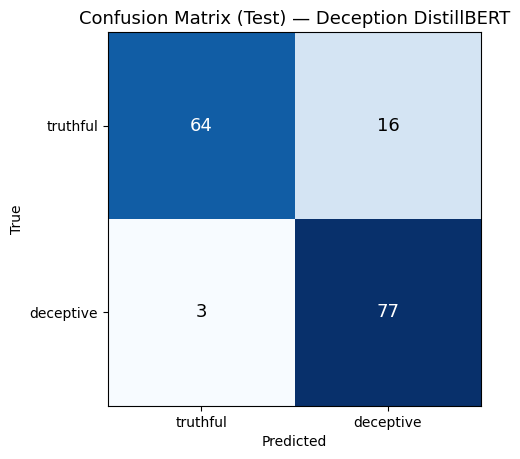

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np

# Get predictions and labels
preds_output = trainer.predict(test_ds)
y_pred = np.argmax(preds_output.predictions, axis=1)
y_true = preds_output.label_ids

# Create confusion matrix
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Truthful", "Deceptive"])

plt.figure(figsize=(5, 5))
plt.imshow(cm, interpolation="nearest", cmap="Blues")
plt.title("Confusion Matrix (Test) — Deception DistillBERT", fontsize=13)
plt.xticks([0, 1], ["truthful", "deceptive"])
plt.yticks([0, 1], ["truthful", "deceptive"])
plt.xlabel("Predicted")
plt.ylabel("True")

for (i, j), v in np.ndenumerate(cm):
    color = "white" if v > cm.max() / 2 else "black"
    plt.text(j, i, str(v), ha="center", va="center", color=color, fontsize=13)

plt.tight_layout()
plt.show()


In [ ]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

# Compute metrics from test predictions
row_test = {
    "Model": "DistilBERT (Fine-tuned, test)",
    "Accuracy": round(accuracy_score(y_true, y_pred), 2),
    "F1": round(f1_score(y_true, y_pred), 2),
    "Precision": round(precision_score(y_true, y_pred), 2),
    "Recall": round(recall_score(y_true, y_pred), 2),
}

# Create dataframe or append to file
try:
    df_test = pd.read_csv("figures/model_comparison_deception.csv")
except FileNotFoundError:
    df_test = pd.DataFrame(columns=["Model", "Accuracy", "F1", "Precision", "Recall"])

df_test = pd.concat([df_test, pd.DataFrame([row_test])], ignore_index=True)

# Save updated comparison table
df_test.to_csv("figures/model_comparison_deception.csv", index=False)
print("Added DistilBERT results to model_comparison_deception.csv")
print(df_test)

Added DistilBERT results to model_comparison_deception.csv
                           Model  Accuracy    F1  Precision  Recall
0                   SVM (TF–IDF)      0.87  0.87       0.85    0.90
1  DistilBERT (Fine-tuned, test)      0.88  0.89       0.83    0.96


In [5]:
import torch, joblib
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import numpy as np
import pandas as pd
from pathlib import Path

# -----------------------------
# Load model, tokenizer, and label map
# -----------------------------
def load_inference_components(artifacts_dir="artifacts/distilbert_deception_sweep/best_model"):
    artifacts_dir = Path(artifacts_dir)
    model = AutoModelForSequenceClassification.from_pretrained(artifacts_dir)
    tokenizer = AutoTokenizer.from_pretrained(artifacts_dir)
    label_map = joblib.load(artifacts_dir / "label_map.joblib")
    inverse_label_map = {v: k for k, v in label_map.items()}
    return model, tokenizer, inverse_label_map


# -----------------------------
# Inference function
# -----------------------------
def predict_deception(texts, model, tokenizer, label_map):
    """
    Predict deception probabilities for given text(s).
    Inputs:
        texts: str or list of str
        model, tokenizer, label_map: loaded components
    Returns:
        DataFrame with columns: text, predicted_label, confidence
    """
    if isinstance(texts, str):
        texts = [texts]

    model.eval()
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    # Tokenize
    encodings = tokenizer(
        texts, padding=True, truncation=True, max_length=256, return_tensors="pt"
    ).to(device)

    # Inference
    with torch.no_grad():
        outputs = model(**encodings)
        probs = torch.nn.functional.softmax(outputs.logits, dim=1)
        preds = torch.argmax(probs, dim=1).cpu().numpy()
        confs = probs.max(dim=1).values.cpu().numpy()

    # Map to labels
    labels = [label_map[p] for p in preds]

    return pd.DataFrame({
        "text": texts,
        "predicted_label": labels,
        "confidence": np.round(confs, 3)
    })

In [ ]:
# -----------------------------
# Example usage
# -----------------------------
# Load everything once
model, tokenizer, label_map = load_inference_components("artifacts/distilbert_deception_sweep/best_model")

# Predict one or multiple reviews
texts = [
    "The host was friendly and the apartment was spotless!",
    "This listing was fake, and the pictures were completely different."
]

results = predict_deception(texts, model, tokenizer, label_map)
print(results)

                                                text predicted_label  \
0  The host was friendly and the apartment was sp...       deceptive   
1  This listing was fake, and the pictures were c...       deceptive   

   confidence  
0       0.959  
1       0.744  


In [ ]:
texts = [
    "The room was spotless and the staff were incredibly friendly.",
    "Best hotel ever! The photos are fake but you should totally stay here!",
    "We waited two hours for check-in, and the manager kept making excuses."
]

results = predict_deception(texts, model, tokenizer, label_map)
print(results)

                                                text predicted_label  \
0  The room was spotless and the staff were incre...       deceptive   
1  Best hotel ever! The photos are fake but you s...       deceptive   
2  We waited two hours for check-in, and the mana...        truthful   

   confidence  
0       0.983  
1       0.987  
2       0.930  


In [9]:
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    Trainer,
    TrainingArguments
)
from datasets import Dataset
import torch
import numpy as np
from sklearn.metrics import precision_recall_curve
import pandas as pd
import matplotlib.pyplot as plt
import os

artifacts_dir = "artifacts/distilbert_deception_sweep/best_model"

model = AutoModelForSequenceClassification.from_pretrained(artifacts_dir)
tokenizer = AutoTokenizer.from_pretrained(artifacts_dir)


# Load and Split Dataset
df = pd.read_csv("data/deception_opinion_cleaned.csv")
df = df.dropna(subset=["text", "label"])
df["label"] = df["label"].astype(int)
df["text"] = df["text"].astype(str)


train_df, temp_df = train_test_split(df, test_size=0.2, stratify=df["label"], random_state=42)
val_df, test_df = train_test_split(temp_df, test_size=0.5, stratify=temp_df["label"], random_state=42)

X_val = val_df["text"].astype(str).tolist()
y_val = val_df["label"].astype(int).tolist()

encodings_val = tokenizer(
    X_val,
    truncation=True,
    padding=True,
    max_length=256,
    return_tensors="pt"
)

val_dataset = Dataset.from_dict({
    "input_ids": encodings_val["input_ids"],
    "attention_mask": encodings_val["attention_mask"],
    "labels": y_val
})

training_args = TrainingArguments(
    output_dir="./tmp_eval",
    per_device_eval_batch_size=32,
    dataloader_drop_last=False,
    report_to="none"
)

trainer = Trainer(
    model=model,
    args=training_args
)

preds_output = trainer.predict(val_dataset)

# Raw logits → probabilities
logits = preds_output.predictions
probs = torch.nn.functional.softmax(torch.tensor(logits), dim=1).numpy()

# Probability of the "deceptive" class (index 1)
y_val_prob = probs[:, 1]
y_val_true = np.array(y_val)

prec, rec, thresh = precision_recall_curve(y_val_true, y_val_prob)
f1 = 2 * (prec * rec) / (prec + rec + 1e-9)
best_idx = np.argmax(f1)
best_thresh = thresh[best_idx]
best_f1 = f1[best_idx]

print(f"Optimal threshold (τ) = {best_thresh:.2f}")
print(f"Validation F1 = {best_f1:.3f}")

# Optional visualization
os.makedirs("Figures", exist_ok=True)
plt.figure(figsize=(6,4))
plt.plot(thresh, f1[:-1], linewidth=2)
plt.axvline(best_thresh, color="red", linestyle="--", label=f"τ={best_thresh:.2f}")
plt.xlabel("Threshold (τ)")
plt.ylabel("F1-score")
plt.title("Threshold Optimization on Validation Set")
plt.legend()
plt.tight_layout()
plt.savefig("figures/deception_threshold_curve.png", dpi=300)
plt.close()

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Optimal threshold (τ) = 0.81
Validation F1 = 0.908
